In [22]:
import cv2
import os
import pandas as pd
import numpy as np
import keras, tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split



In [228]:
def extract(img, smaller):
        
    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    if(smaller):
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

        # Applying dilation on the threshold image
        dilation = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, rect_kernel, iterations = 1)
        # dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    else:
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

        # Applying dilation on the threshold image
        dilation = cv2.dilate(thresh1, rect_kernel, iterations = 2)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                    cv2.CHAIN_APPROX_NONE)

    return contours

In [194]:
def boundingbox(img_path, model):
    img = cv2.imread(img_path)
    contours = extract(img, False)

    sum = 0
    y_pred = []
    boxes = []
    im = img.copy()
    crops = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (255, 0, 0), 2)
            
        # Cropping the text block
        cropped = img[y:y + h, x:x + w]

        # extract each alphabet from each block
        contours2 = extract(cropped, True)
        
        for i in contours2:
            # count alphabets 
            sum += 1

            x2, y2, w2, h2 = cv2.boundingRect(i)
            
            cropped2 = img[y+y2: y+y2+h2, x+x2: x+x2+w2]
            
            boxes.append([x+x2, y+y2, x+x2 + w2, y+y2 + h2]) 

            cropped2 = cv2.resize(cropped2, (64,64))
            
            crops.append(cropped2)

            cropped2 = cropped2.reshape((1, 64, 64, 3))

            y_pred.append(model.predict(cropped2))

    
    order = np.argsort([x[0] for x in boxes])
    boxes = [boxes[x] for x in order]
    crops = [crops[x] for x in order]
    y_pred = [y_pred[x] for x in order]
    
    y_pred = np.array(y_pred)
    return sum, y_pred, boxes, im, crops


In [242]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# # Block 3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# # Block 4
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))  # Adding dropout
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))  # Adding dropout
model.add(Dense(62, activation='softmax'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 conv2d_129 (Conv2D)         (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_130 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 conv2d_131 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                               

In [208]:
# each classes(62 classes) has 55 images 
model_training_csv = os.path.join(os.getcwd(), 'alphabets/english.csv')
model_image_training = os.path.join(os.getcwd(), 'alphabets')

# make dataframe for training model 
model_training_df = pd.read_csv(model_training_csv)
# add columns of image
model_training_df['img'] = ''
# get image for each image name
for i in range(len(model_training_df)):
    img_path = os.path.join(model_image_training, model_training_df.at[i, 'image'])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))

    model_training_df.at[i, 'img'] = img
# get all class names
class_names = model_training_df.label.unique()

# split each class equaly
x_train, y_train, x_test, y_test = [], [], [], []
temp = []
for name in class_names:
    split = model_training_df[model_training_df.label == name]
    X = split['img']
    Y = split['label']
    Y = [np.where(class_names == label)[0] for label in Y]

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.8)

    x_train.extend(X_train)
    y_train.extend(Y_train)
    x_test.extend(X_test)
    y_test.extend(Y_test)


# shuffle order of train and test data
temp_x_train, temp_y_train, temp_x_test, temp_y_test = [], [], [], []

train_rand_order = np.arange(len(x_train))
test_rand_order = np.arange(len(x_test))
np.random.shuffle(train_rand_order)
np.random.shuffle(test_rand_order)
for i in train_rand_order:
    temp_x_train.append(x_train[i])
    temp_y_train.append(y_train[i])

for j in test_rand_order:
    temp_x_test.append(x_test[j])
    temp_y_test.append(y_test[j])    

x_train = np.array(temp_x_train, dtype=np.float32)
x_test = np.array(temp_x_test, dtype=np.float32)
y_train = np.array(temp_y_train)
y_test = np.array(temp_y_test)


# one-hot-encoded the label
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

In [243]:
batch_size = 32

# initiate RMSprop optimizer
# Using M1 mac
# opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0005)
opt = keras.optimizers.legacy.Adam(learning_rate=0.0005)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)


Epoch 1/10
86/86 [==============================] - 9s 97ms/step - loss: 4.2607 - accuracy: 0.0180 - val_loss: 4.1068 - val_accuracy: 0.0249
Epoch 2/10
86/86 [==============================] - 8s 98ms/step - loss: 3.9796 - accuracy: 0.0488 - val_loss: 3.4779 - val_accuracy: 0.1173
Epoch 3/10
86/86 [==============================] - 9s 100ms/step - loss: 3.0360 - accuracy: 0.2119 - val_loss: 2.2551 - val_accuracy: 0.3944
Epoch 4/10
86/86 [==============================] - 9s 101ms/step - loss: 2.0425 - accuracy: 0.4410 - val_loss: 1.7270 - val_accuracy: 0.5044
Epoch 5/10
86/86 [==============================] - 9s 104ms/step - loss: 1.4673 - accuracy: 0.5751 - val_loss: 1.4193 - val_accuracy: 0.5689
Epoch 6/10
86/86 [==============================] - 9s 105ms/step - loss: 1.1152 - accuracy: 0.6573 - val_loss: 1.1916 - val_accuracy: 0.6466
Epoch 7/10
86/86 [==============================] - 9s 105ms/step - loss: 0.8878 - accuracy: 0.7309 - val_loss: 1.1267 - val_accuracy: 0.6686
Epoch 8/

In [195]:
train_img_path = os.path.join(os.getcwd(), "archive/train_v2/train")
test_img_path = os.path.join(os.getcwd(), "archive/test_v2/test")

train_csv_path = os.path.join(os.getcwd(), "archive/written_name_train_v2.csv")
test_csv_path = os.path.join(os.getcwd(), "archive/written_name_test_v2.csv")



df = pd.read_csv(test_csv_path)
cnt = 0
im = 0
boxes = []

# for i in range (df.shape[0]):
for i in range (37867,37868):
    print(df['FILENAME'][i])
    img_name = os.path.join(test_img_path, df['FILENAME'][i])
    num_of_char, y_pred, boxes, img, crop = boundingbox(img_name, model)
    if num_of_char == len(str(df['IDENTITY'][i])):
        cnt += 1
    im = img
    # cnt = num_of_char

TEST_37868.jpg
1/1 [==============================] - 0s 11ms/step


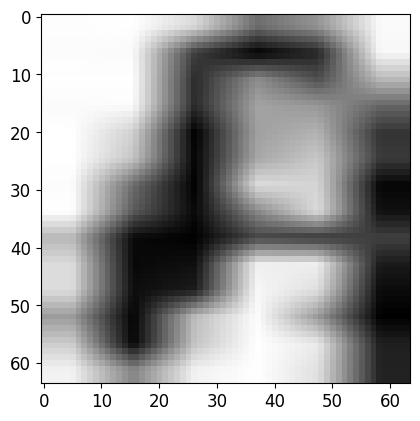

In [199]:
plt.imshow(crop[3])

In [200]:
word = ''
for i in y_pred:
    m = np.argmax(i)
    word += class_names[m]
print(word)
print(boxes)

TiIl
[[12, 14, 20, 28], [30, 14, 37, 26], [46, 15, 55, 28], [65, 14, 71, 28]]


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predict Y
ans Y


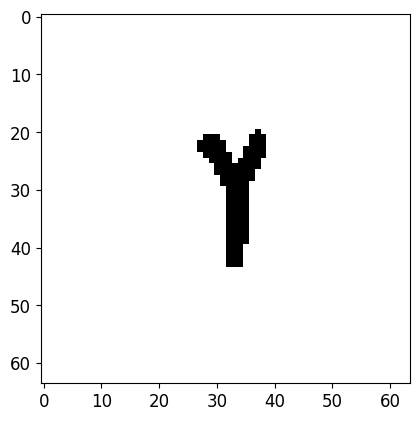

In [70]:
i = 932

ans = model.predict(x_test[i].reshape((1, 64, 64, 3)))
print('predict ' + class_names[np.argmax(ans)])
print('ans ' + class_names[np.argmax(y_test[i])])
plt.imshow(x_test[i])

In [72]:
def adjust_color(image):
    dark_threshold = 50  # Colors lower than this will be darkened
    light_threshold = 200  # Colors higher than this will be lightened

    # Create a mask for dark and light pixels
    dark_mask = image < dark_threshold
    light_mask = image > light_threshold

    # Increase color for dark pixels
    image[dark_mask] = np.minimum(image[dark_mask] + 50, 255)

    # Decrease color for light pixels
    image[light_mask] = np.maximum(image[light_mask] - 50, 0)

    return image

In [244]:
ans = 'StandardRNNshavepoormemory'
num_of_char, y_pred, boxes, img, crop = boundingbox(os.path.join(os.getcwd(), "com_text3.png"), model)
print(num_of_char)
word = ''
for i in y_pred:
    m = np.argmax(i)
    word += class_names[m]
print(word)


1/1 [==============================] - 0s 11ms/step
26
oTCTzCTzTXXSwCVZzZZTfZfZTY


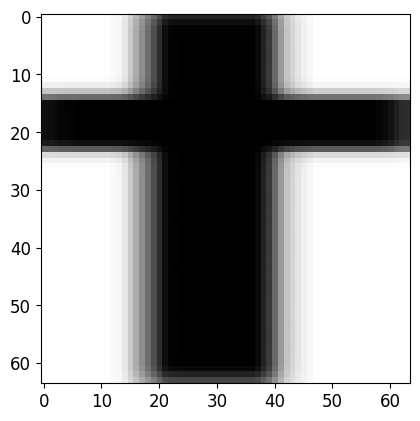

In [245]:
# save resulting image
for x1, y1, x2, y2 in boxes:
    rect = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(img)
plt.imshow(crop[1])

In [246]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.226384, Accuracy: 0.934384
 Test Loss: 1.069719, Accuracy: 0.687683

[[5 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 9 ... 0 0 1]
 ...
 [0 0 0 ... 9 0 2]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 1 5]]


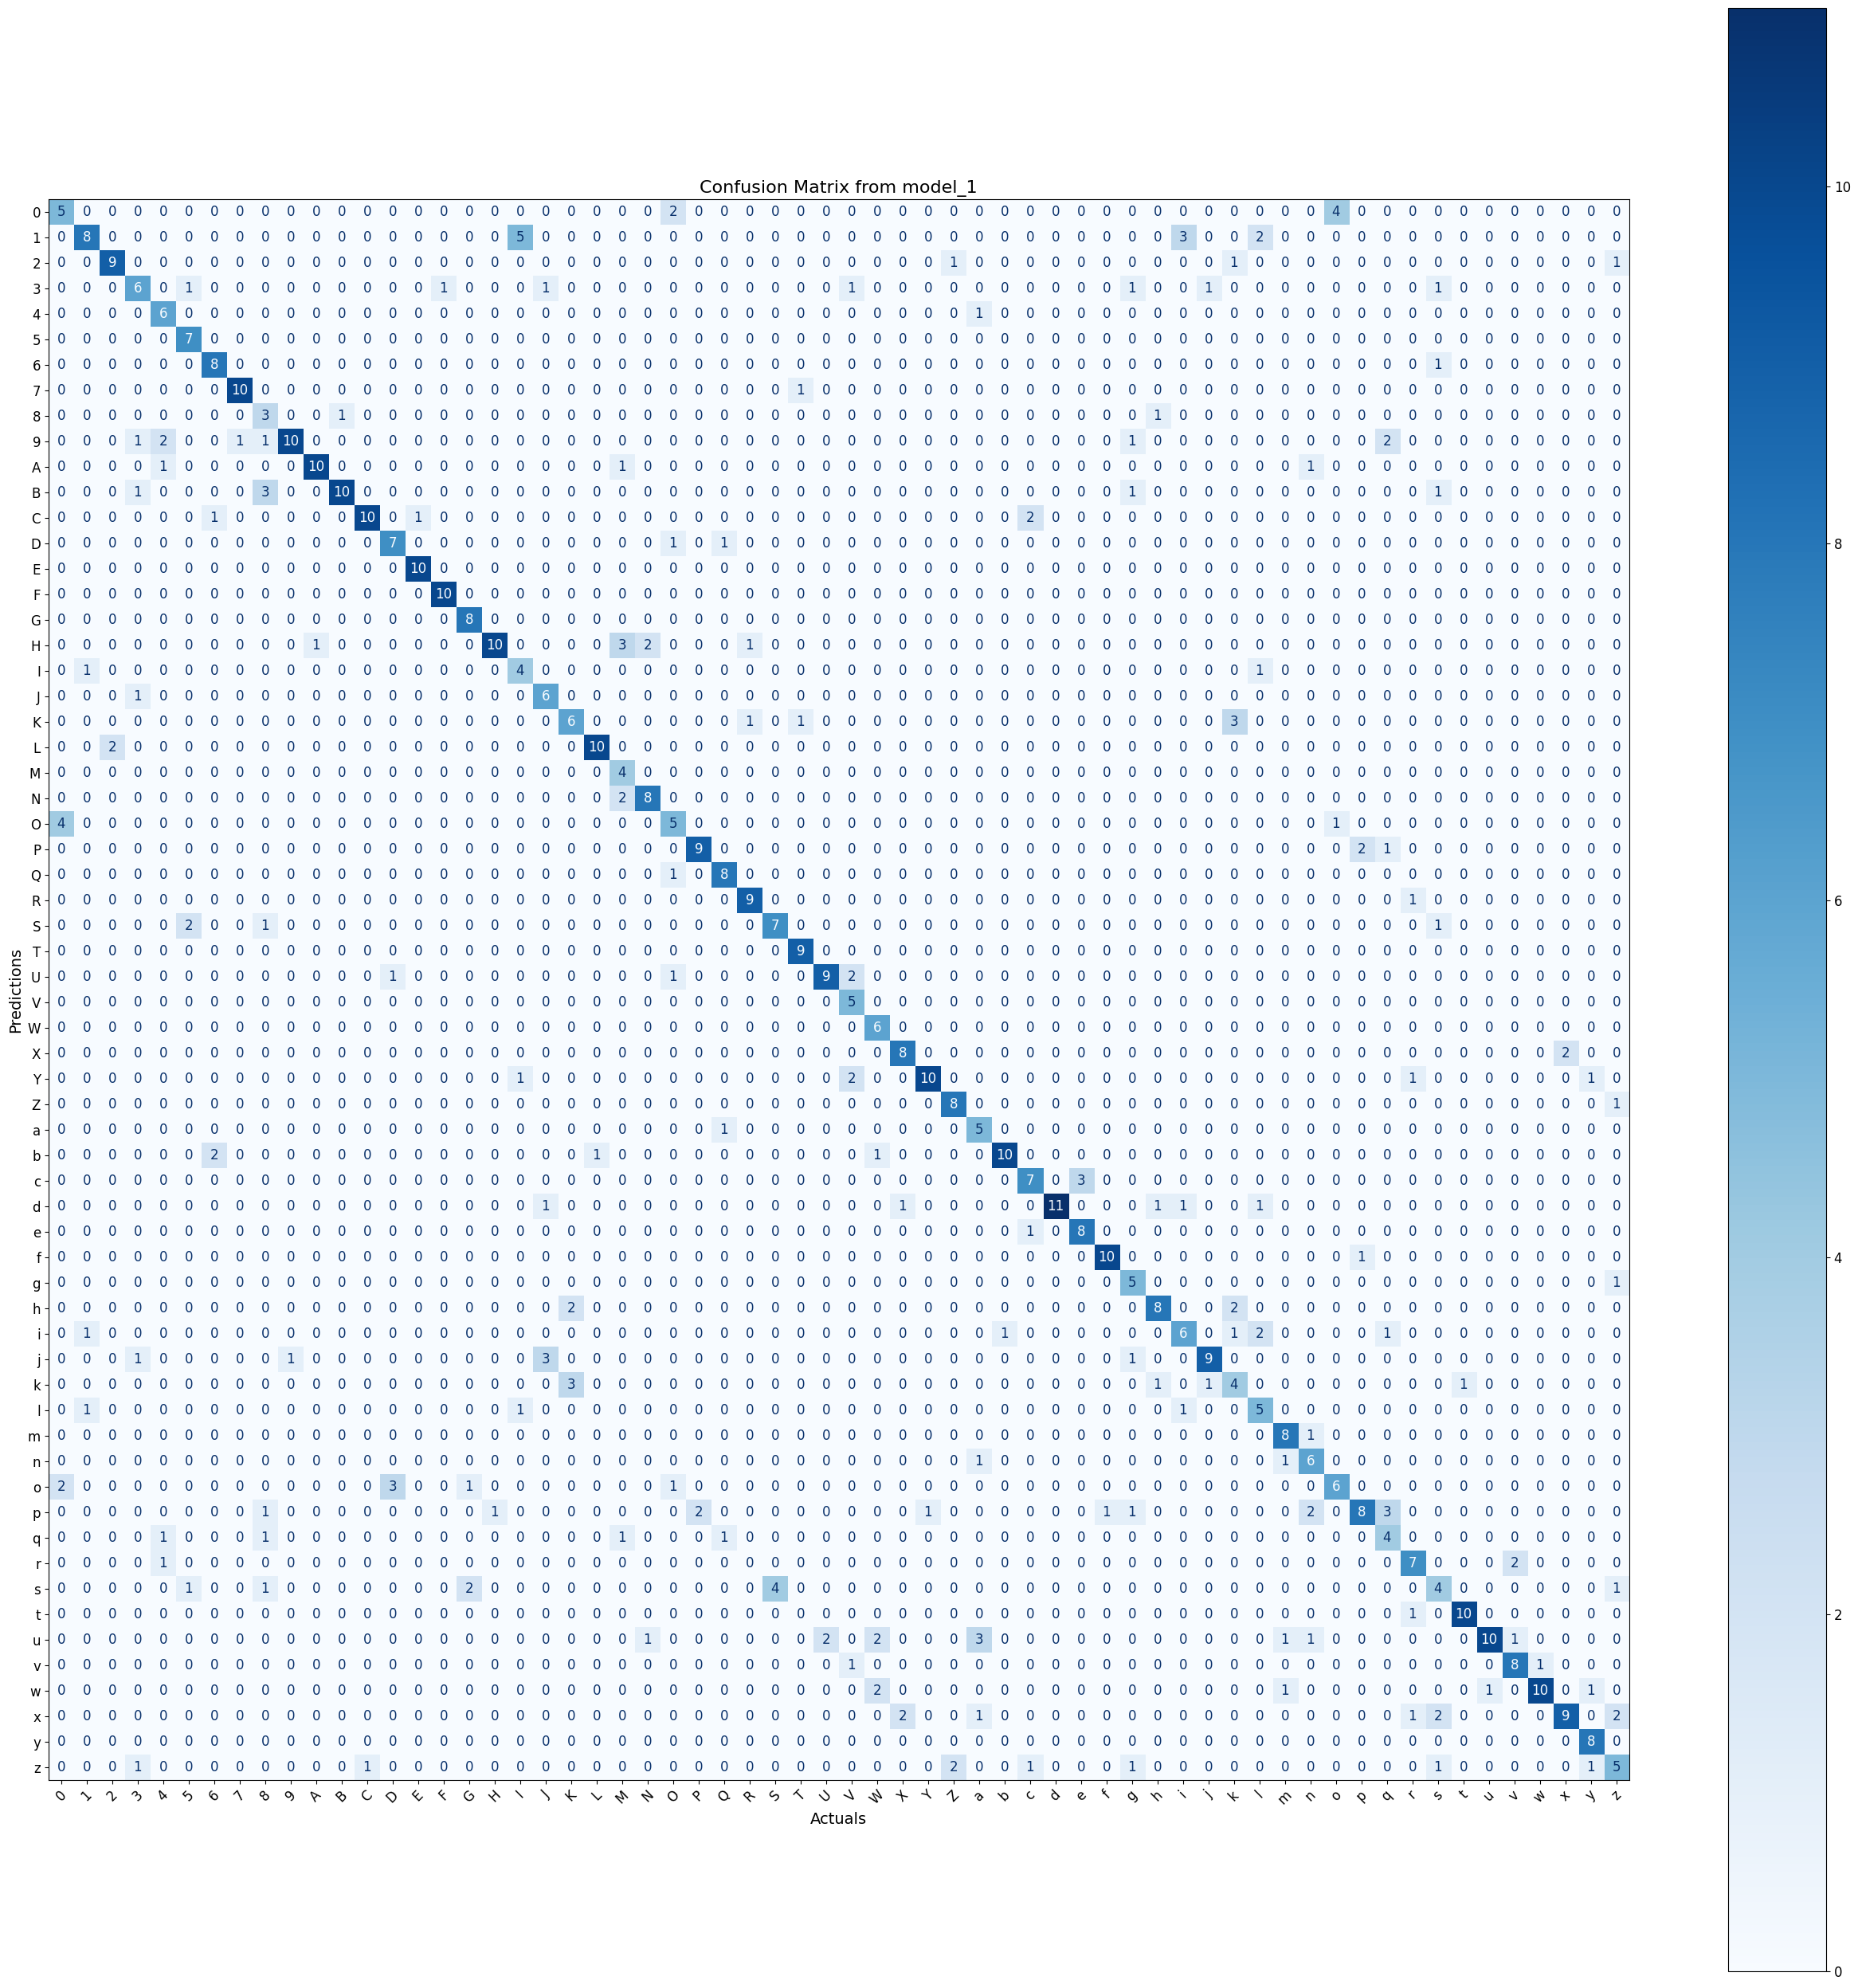

In [247]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(32, 32))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [251]:
np.set_printoptions(precision=2)
# classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names)
print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

           0       0.45      0.45      0.45        11
           1       0.44      0.73      0.55        11
           2       0.75      0.82      0.78        11
           3       0.46      0.55      0.50        11
           4       0.86      0.55      0.67        11
           5       1.00      0.64      0.78        11
           6       0.89      0.73      0.80        11
           7       0.91      0.91      0.91        11
           8       0.60      0.27      0.37        11
           9       0.56      0.91      0.69        11
           A       0.77      0.91      0.83        11
           B       0.62      0.91      0.74        11
           C       0.71      0.91      0.80        11
           D       0.78      0.64      0.70        11
           E       1.00      0.91      0.95        11
           F       1.00      0.91      0.95        11
           G       1.00      0.73      0.84        11
           H       0.59    